<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mandelbrot

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import io
import imageio

from numba import jit, njit, prange

**Implementation**

In [10]:
def calculate_z(a, b, max_iters, limit=100):
    C = complex(a, b)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + C
        if ((z.real * z.real + z.imag * z.imag) >= limit):
            return i
    return max_iters

def julia_set(x_min, x_max, y_min, y_max, size, iters, limit):
    image = np.zeros((size, size), dtype=np.uint16)
    height = image.shape[0]
    width = image.shape[1]

    size_x = (x_max - x_min) / width
    size_y = (y_max - y_min) / height

    for x in prange(width):
        real = x_min + x * size_x
        for y in prange(height):
            imag = y_min + y * size_y
            color = calculate_z(real, imag, iters)
            image[y, x] = color
    return image

**Numba implementation**

In [19]:
@njit(fastmath=True)
def calculate_z_jit(x, y, max_iters, limit=100):
    C = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + C
        if np.sqrt(z.real*z.real + z.imag*z.imag) >= limit:
            return i
    return max_iters

@njit(parallel=True, fastmath=True)
def julia_set_jit(x_min, x_max, y_min, y_max, size, iters, limit):
    image = np.zeros((size, size), dtype=np.uint16)
    height = image.shape[0]
    width = image.shape[1]

    size_x = (x_max - x_min) / width
    size_y = (y_max - y_min) / height
    for x in prange(width):
        real = x_min + x * size_x
        for y in prange(height):
            imag = y_min + y * size_y
            color = calculate_z_jit(real, imag, iters)
            image[y, x] = color
    return image

Text(0, 0.5, 'Im(z)')

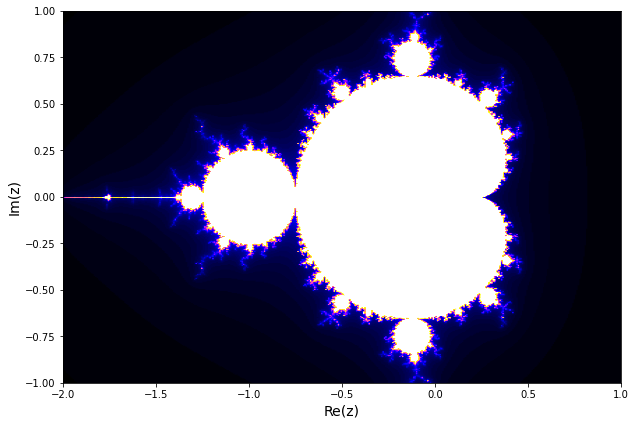

In [39]:
julia = julia_set_jit(-2.0, 1.0, -1.0, 1.0, 400, 100, 100)
plt.figure(figsize=(10, 8))
plt.imshow(julia, cmap='gnuplot2', extent=(-2, 1, -1, 1))
plt.xlabel('Re(z)', fontsize=14)
plt.ylabel('Im(z)', fontsize=14)

# Profile

**Mandelbrot code is profiled**

In [7]:
import cProfile
cProfile.run('julia_set_jit(-2.0, 1.0, -1.0, 1.0, 400, 100, 100)')

         4 function calls in 0.051 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.051    0.051    0.051    0.051 <ipython-input-4-f141af66f503>:11(get_julia_set_jit)
        1    0.000    0.000    0.051    0.051 <string>:1(<module>)
        1    0.000    0.000    0.051    0.051 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




# Graph

**Graph measuring computation time is given (OX - number of total iterations, OY - computational time, two curves - one for numba version, the other for regular version)**

In [ ]:
steps = np.arange(1, 1001, 300)
measure_time_np = np.zeros(steps.size)
measure_time_jit = np.zeros(steps.size)
for i, step in enumerate(steps):
    print(f'\r{i+1}/{steps.size}', end='')
    time = %timeit -o -q -r 10 -n 3 julia_set(-2.0, 1.0, -1.0, 1.0, 400, step, 100)
    measure_time_np[i] = time.best
    time = %timeit -o -q -r 10 -n 3  julia_set_jit(-2.0, 1.0, -1.0, 1.0, 400, step, 100)
    measure_time_jit[i] = time.best

Text(0, 0.5, 'Computational time')

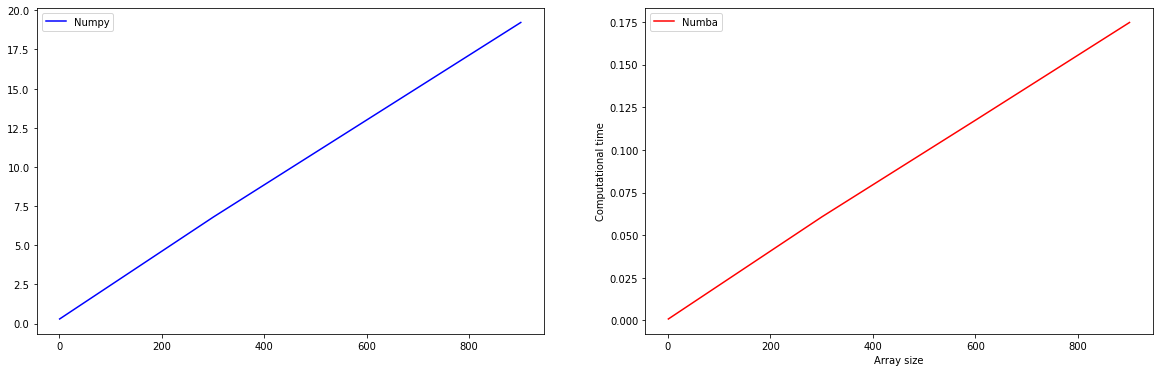

In [60]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(steps, measure_time_np, label='Numpy', color='blue')
plt.legend()
plt.subplot(122)
plt.plot(steps, measure_time_jit, label='Numba', color='red')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computational time')

Text(0, 0.5, 'Computational time')

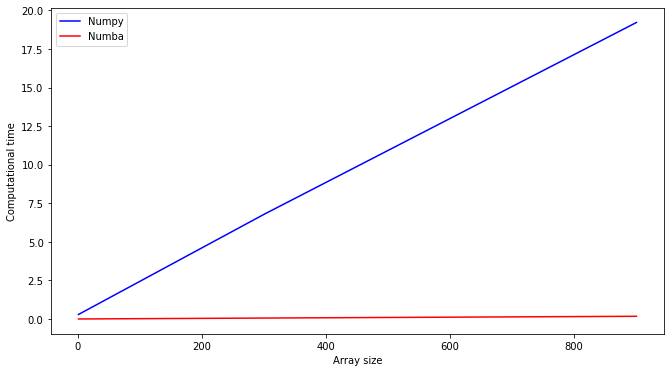

In [57]:
plt.figure(figsize=(11, 6))
plt.plot(steps, measure_time_np, label='Numpy', color='blue')
plt.plot(steps, measure_time_jit, label='Numba', color='red')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computational time')